<a href="https://colab.research.google.com/github/ianmateusES/dio-image_recommendation_system/blob/main/sistema_recomendação_por_imagens_digitais.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sistema de Recomendação por Imagens Digitais

## 1. Bibliotecas

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from shutil import move
from pathlib import Path
from tqdm import tqdm

# tqdm é um pacote para Python que permite acompanhar o progresso de loops
# com barras de progresso e estimar TTC (Time To Completion)
tqdm.pandas()

## 2. Habiltando Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 3. Importando biblioteca do Kaggle

In [3]:
# Gerando arquivo de credenciais
%%writefile kaggle.json
{"username":"User","key":"number key"}

Writing kaggle.json


In [4]:
%%time
# Baixando e instalando Kaggle
!pip install -q -U kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for kaggle: filename=kaggle-1.5.13-py3-none-any.whl size=77717 sha256=a5adbb3532d83502971558e2672538ab02d2d5cd9fcd7d138cf22bffd73d32a6
  Stored in directory: /root/.cache/pip/wheels/f3/16/ff/34e7d368370d4fd68bb749a59f1d2639ed66f3c14358e340a1
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.13
    Uninstalling kaggle-1.5.13:
      Successfully uninstalled kaggle-1.5.13
CPU times: user 93.1 ms, sys: 11.1 ms, total: 104 ms
Wall time: 11 s


## 4. Obtendo os dados

In [ ]:
%%time
# Baixando e descompactando os dados
!kaggle datasets download -d paramaggarwal/fashion-product-images-small
!unzip fashion-product-images-small.zip

In [6]:
%%time
# Criando o diretorio que vai conter nossas imagens e as categorias
os.mkdir('/content/Fashion_data')
os.chdir('/content/Fashion_data')

df = pd.read_csv('/content/styles.csv', usecols=['id','masterCategory']).reset_index()
df['id'] = df['id'].astype('str')

all_images = os.listdir('/content/images/')
co = 0
os.mkdir('/content/Fashion_data/categories')
for image in tqdm(all_images):
    category = df[df['id'] == image.split('.')[0]]['masterCategory']
    category = str(list(category)[0])
    if not os.path.exists(os.path.join('/content/Fashion_data/categories', category)):
        os.mkdir(os.path.join('/content/Fashion_data/categories', category))
    path_from = os.path.join('/content/images', image)
    path_to = os.path.join('/content/Fashion_data/categories', category, image)
    move(path_from, path_to)
    co += 1

100%|██████████| 44441/44441 [03:10<00:00, 233.59it/s]

CPU times: user 2min 50s, sys: 3.72 s, total: 2min 54s
Wall time: 3min 10s


## 5. Transferência de aprendizado

Baixando o modelo de imagem pré-treinado e adicionando duas camadas adicionais: a primeira camada é uma camada de vetor de recursos e a segunda camada é a camada de classificação.

Vamos treinar apenas essas 2 camadas em nossos dados e, após o treinamento, selecionaremos a camada de vetor de recursos como saída de nosso codificador ajustado. Depois de ajustar o modelo, salvaremos o extrator de recursos para uso posterior.

In [7]:
import os
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub

print("TF version:", tf.__version__)
print("Hub version:", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

TF version: 2.12.0
Hub version: 0.13.0
GPU is available


In [8]:
MODULE_HANDLE = 'https://tfhub.dev/google/bit/m-r50x3/1'
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
N_FEATURES = 256
data_dir = '/content/Fashion_data/categories'

print("Using {} with input size {}".format(MODULE_HANDLE, IMAGE_SIZE))

Using https://tfhub.dev/google/bit/m-r50x3/1 with input size (224, 224)


In [9]:
%%time
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(
  target_size=IMAGE_SIZE, batch_size=BATCH_SIZE, interpolation="bilinear"
)

valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation",
    shuffle=False, **dataflow_kwargs
)

do_data_augmentation = False 
if do_data_augmentation:
  train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
      rotation_range=40, horizontal_flip=True,
      width_shift_range=0.2, height_shift_range=0.2,
      shear_range=0.2, zoom_range=0.2, **datagen_kwargs
  )
else:
  train_datagen = valid_datagen

train_generator = train_datagen.flow_from_directory(
    data_dir, subset="training",
    shuffle=True, **dataflow_kwargs
)

Found 8886 images belonging to 7 classes.
Found 35555 images belonging to 7 classes.
CPU times: user 659 ms, sys: 91.4 ms, total: 751 ms
Wall time: 703 ms


In [10]:
%%time
# Construindo o modelo com Keras
print("Building model with", MODULE_HANDLE)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(MODULE_HANDLE, trainable=False),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(N_FEATURES, kernel_regularizer=tf.keras.regularizers.l2(0.0001)),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, kernel_regularizer=tf.keras.regularizers.l2(0.0001))
])
model.build((None,)+IMAGE_SIZE+(3,))
model.summary()

Building model with https://tfhub.dev/google/bit/m-r50x3/1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 6144)              211174080 
                                                                 
 dropout (Dropout)           (None, 6144)              0         
                                                                 
 dense (Dense)               (None, 256)               1573120   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 212,748,999
Trainable params: 1,574,919
Non-trainable params: 211,174,080
_________________________________________

In [11]:
%%time
# Compilando o modelo

# Definir otimizador e perda
lr = 0.003 * BATCH_SIZE / 512 
SCHEDULE_LENGTH = 500
SCHEDULE_BOUNDARIES = [200, 300, 400]

# Reduzindo a taxa de aprendizado por um fator de 10 em SCHEDULE_BOUNDARIES
lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
  boundaries=SCHEDULE_BOUNDARIES, values=[lr, lr*0.1, lr*0.001, lr*0.0001]
)
optimizer = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

model.compile(
  optimizer=optimizer,
  loss=loss_fn,
  metrics=['accuracy']
)

CPU times: user 38.8 ms, sys: 1.9 ms, total: 40.7 ms
Wall time: 77.5 ms


In [12]:
%%time
# Treinando o modelo
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = valid_generator.samples // valid_generator.batch_size

hist = model.fit(
  train_generator, epochs=5,
  steps_per_epoch=steps_per_epoch,
  validation_data=valid_generator,
  validation_steps=validation_steps
).history

Epoch 1/5
1111/1111 [==============================] - 404s 342ms/step - loss: 0.2596 - accuracy: 0.9687 - val_loss: 0.1447 - val_accuracy: 0.9878
Epoch 2/5
1111/1111 [==============================] - 377s 339ms/step - loss: 0.1995 - accuracy: 0.9763 - val_loss: 0.1446 - val_accuracy: 0.9878
Epoch 3/5
1111/1111 [==============================] - 367s 330ms/step - loss: 0.1932 - accuracy: 0.9769 - val_loss: 0.1445 - val_accuracy: 0.9878
Epoch 4/5
1111/1111 [==============================] - 377s 339ms/step - loss: 0.1876 - accuracy: 0.9775 - val_loss: 0.1443 - val_accuracy: 0.9878
Epoch 5/5
1111/1111 [==============================] - 377s 339ms/step - loss: 0.1920 - accuracy: 0.9768 - val_loss: 0.1442 - val_accuracy: 0.9878
CPU times: user 14min 43s, sys: 1min 31s, total: 16min 14s
Wall time: 32min 1s


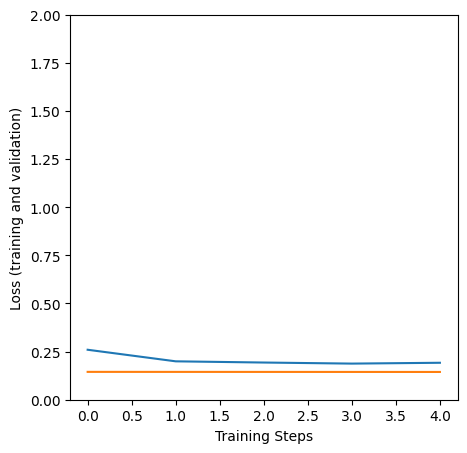

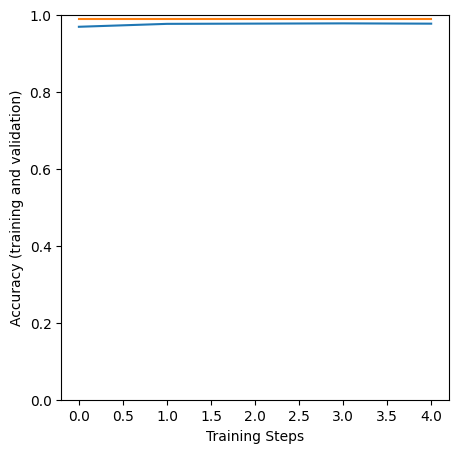

In [13]:
# Perda e acurácia do treinamento do modelo
plt.figure(figsize=(5,5))
plt.ylabel("Loss (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])

plt.figure(figsize=(5,5))
plt.ylabel("Accuracy (training and validation)")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(hist["accuracy"])
plt.plot(hist["val_accuracy"])

In [14]:
%%time
# Salvando o modelo
root_path = '/content/drive/MyDrive/study/dio/machine_learning_specialist/processamento_imagens/data'
if not os.path.exists(root_path):
    os.mkdir(root_path)

feature_extractor = tf.keras.Model(inputs=model.inputs, outputs=model.layers[-3].output)
feature_extractor.save(f'{root_path}/bit_feature_extractor', save_format='tf')

saved_model_path = f'{root_path}/bit_model'
tf.saved_model.save(model, saved_model_path)

CPU times: user 32 s, sys: 3.01 s, total: 35 s
Wall time: 41.6 s


## 6. Vetorização dos dados

Usando o codificador (preparado no passo 3) para codificar as imagens (preparado no passo 2). Salvaremos o vetor de recursos de cada imagem como uma matriz em um diretório. Após o processamento, salvaremos essas incorporações para uso posterior.

In [15]:
img_paths = []
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  img_paths.append(path)
np.random.shuffle(img_paths)

In [16]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.io.decode_jpeg(img, channels=3)
  img = tf.image.resize_with_pad(img, 224, 224)
  img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  return img

In [32]:
%%time
# Recuperando o modelo que treinamos anteriormente
root_path = '/content/drive/MyDrive/study/dio/machine_learning_specialist/processamento_imagens/data'
TRANSFER_LEARNING_FLAG = 1
if TRANSFER_LEARNING_FLAG:
  module = tf.keras.models.load_model(f'{root_path}/bit_feature_extractor')
else:
  module_handle = "https://tfhub.dev/google/bit/s-r50x3/ilsvrc2012_classification/1" 
  module = hub.load(module_handle)

CPU times: user 20.9 s, sys: 787 ms, total: 21.7 s
Wall time: 34.9 s


In [33]:
# Vetorizando as imagens
imgvec_path = '/content/img_vectors/'
Path(imgvec_path).mkdir(parents=True, exist_ok=True)

In [34]:
%%time
for filename in tqdm(img_paths[:5000]):
  img = load_img(str(filename))
  features = module(img)
  feature_set = np.squeeze(features)
  outfile_name = os.path.basename(filename).split('.')[0] + ".npz"
  out_path_file = os.path.join(imgvec_path, outfile_name)
  np.savetxt(out_path_file, feature_set, delimiter=',')

100%|██████████| 5000/5000 [04:00<00:00, 20.76it/s]

CPU times: user 3min 53s, sys: 3.93 s, total: 3min 57s
Wall time: 4min


## 7. Metadados e indexação

Atribuiremos um id exclusivo a cada imagem e criaremos dicionários para localizar as informações dessa imagem:

1. ID da imagem para o dicionário de nome da imagem;
2. ID da imagem para o dicionário de vetores de recursos da imagem e;
3. (opcional) ID da imagem para ID do produto de metadados dicionário. Também criaremos um ID de imagem para a indexação de vetores de recursos de imagem.

Em seguida, salvaremos esses dicionários e objetos de índice para uso posterior.

In [35]:
!pip install -q annoy #https://sds-aau.github.io/M3Port19/portfolio/ann/

In [36]:
import glob
import json
import pickle
from IPython.display import Image as dispImage
from annoy import AnnoyIndex
from scipy import spatial

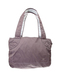

In [37]:
# Testando visualização de imagem
test_img = '/content/Fashion_data/categories/Accessories/1941.jpg'
dispImage(test_img)

In [38]:
%%time
root_path = '/content/drive/MyDrive/study/dio/machine_learning_specialist/processamento_imagens/data'
styles = pd.read_csv('/content/styles.csv', error_bad_lines=False)
styles['id'] = styles['id'].astype('str')
styles.to_csv(f'{root_path}/styles.csv', index=False)

<timed exec>:2: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


Skipping line 6044: expected 10 fields, saw 11
Skipping line 6569: expected 10 fields, saw 11
Skipping line 7399: expected 10 fields, saw 11
Skipping line 7939: expected 10 fields, saw 11
Skipping line 9026: expected 10 fields, saw 11
Skipping line 10264: expected 10 fields, saw 11
Skipping line 10427: expected 10 fields, saw 11
Skipping line 10905: expected 10 fields, saw 11
Skipping line 11373: expected 10 fields, saw 11
Skipping line 11945: expected 10 fields, saw 11
Skipping line 14112: expected 10 fields, saw 11
Skipping line 14532: expected 10 fields, saw 11
Skipping line 15076: expected 10 fields, saw 12
Skipping line 29906: expected 10 fields, saw 11
Skipping line 31625: expected 10 fields, saw 11
Skipping line 33020: expected 10 fields, saw 11
Skipping line 35748: expected 10 fields, saw 11
Skipping line 35962: expected 10 f

CPU times: user 579 ms, sys: 10.2 ms, total: 589 ms
Wall time: 661 ms


In [39]:
def match_id(fname):
  return styles.index[styles.id==fname].values[0]

In [40]:
# Definindo estruturas de dados como dict vazio
file_index_to_file_name = {}
file_index_to_file_vector = {}
file_index_to_product_id = {}

# Configurando parâmetros irritantes
dims = 256
n_nearest_neighbors = 20
trees = 10000

# Lê todos os nomes de arquivos que armazenam vetores de recursos
allfiles = glob.glob('/content/img_vectors/*.npz')

annoyIndexInstance = AnnoyIndex(dims, metric='angular')

In [41]:
%%time
for findex, fname in tqdm(enumerate(allfiles)):
  file_vector = np.loadtxt(fname)
  file_name = os.path.basename(fname).split('.')[0]
  file_index_to_file_name[findex] = file_name
  file_index_to_file_vector[findex] = file_vector
  try:
    file_index_to_product_id[findex] = match_id(file_name)
  except IndexError:
    pass 
  annoyIndexInstance.add_item(findex, file_vector)

5000it [00:41, 120.54it/s]

CPU times: user 28.4 s, sys: 494 ms, total: 28.9 s
Wall time: 41.5 s


In [42]:
%%time
annoyIndexInstance.build(trees)
annoyIndexInstance.save('annoyIndexInstance.ann')

CPU times: user 46.5 s, sys: 1.23 s, total: 47.7 s
Wall time: 55.6 s


True

In [43]:
root_path = '/content/drive/MyDrive/study/dio/machine_learning_specialist/processamento_imagens/data'
annoyIndexInstance.save(f'{root_path}/indexer.ann')
pickle.dump(file_index_to_file_name, open(f"{root_path}/file_index_to_file_name.p", "wb"))
pickle.dump(file_index_to_file_vector, open(f"{root_path}/file_index_to_file_vector.p", "wb"))
pickle.dump(file_index_to_product_id, open(f"{root_path}/file_index_to_product_id.p", "wb"))

## 8. Testando localmente

In [44]:
from PIL import Image
import matplotlib.image as mpimg

CPU times: user 99.1 ms, sys: 3.86 ms, total: 103 ms
Wall time: 991 ms


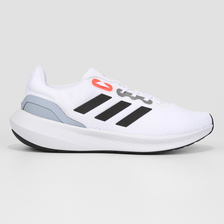

In [45]:
%%time
img_addr = 'https://static.netshoes.com.br/produtos/tenis-adidas-runfalcon-30-masculino/28/FB8-4501-028/FB8-4501-028_zoom1.jpg?ts=1678448317&ims=544x'

!wget -q -O img.jpg $img_addr
test_img = 'img.jpg'
topK = 4

#np.squeeze : https://www.scaler.com/topics/numpy-squeeze/
test_vec = np.squeeze(module(load_img(test_img)))

basewidth = 224
img = Image.open(test_img)
wpercent = (basewidth/float(img.size[0]))
hsize = int((float(img.size[1])*float(wpercent)))
img = img.resize((basewidth,hsize), Image.ANTIALIAS)
img

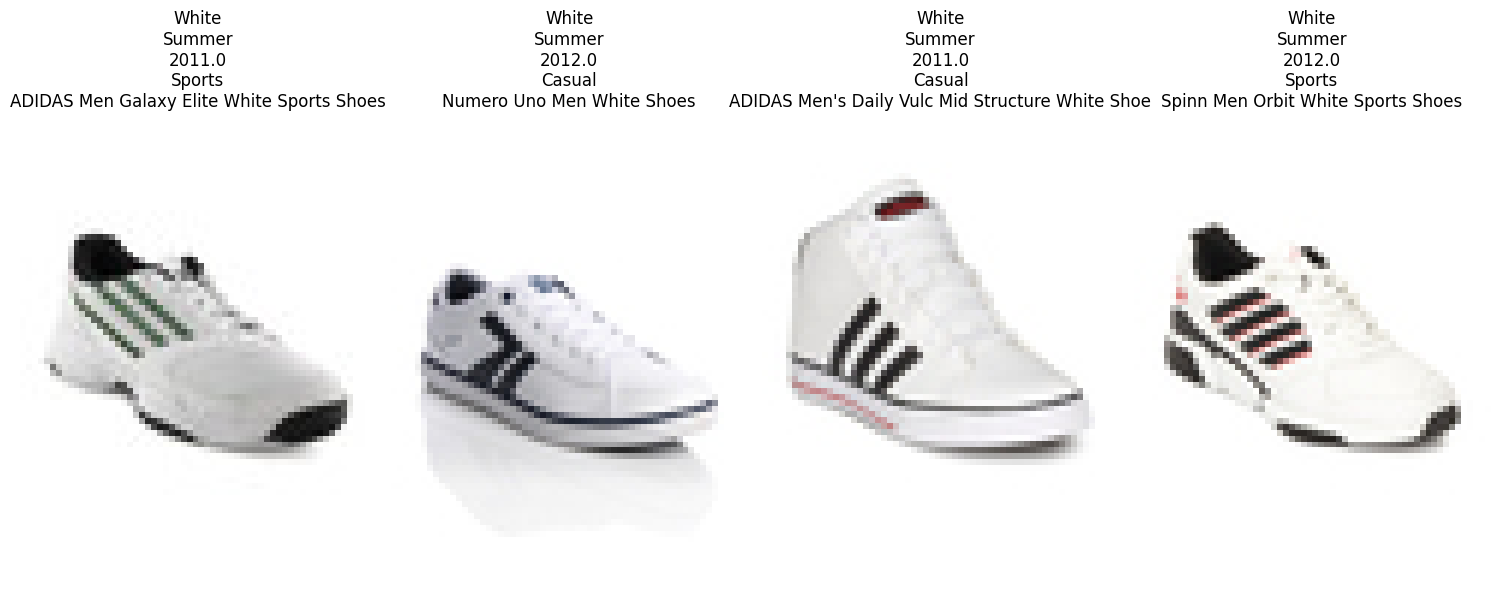

CPU times: user 741 ms, sys: 395 ms, total: 1.14 s
Wall time: 1.69 s


In [46]:
%%time
# Gerando recomendações
path_dict = {}
for path in Path('/content/Fashion_data/categories').rglob('*.jpg'):
  path_dict[path.name] = path

nns = annoyIndexInstance.get_nns_by_vector(test_vec, n=topK)
plt.figure(figsize=(15, 15))
for i in range(topK):
  x = file_index_to_file_name[nns[i]]
  x = path_dict[x+'.jpg']
  y = file_index_to_product_id[nns[i]]
  title = '\n'.join([str(j) for j in list(styles.loc[y].values[-5:])])
  plt.subplot(1, topK, i+1)
  plt.title(title)
  plt.imshow(mpimg.imread(x))
  plt.axis('off')
plt.tight_layout()
plt.show()